In [1]:
pip install -U scikit-learn

In [2]:
# Standard imports
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Set new random seeds
np.random.seed(123)
tf.random.set_seed(123)

In [3]:
# Load and preprocess malaria dataset
malaria_data, info = tfds.load('malaria', split='train', with_info=True)
images = []
labels = []

# Resize to 64x64 instead of 32x32 for better feature extraction
for example in tfds.as_numpy(malaria_data):
    img = resize(example['image'], (64, 64)).astype(np.float32)
    images.append(img)
    labels.append(example['label'])
    if len(images) == 27558:
        break

X_data = np.array(images)
y_data = np.array(labels)

# Split data into training, validation, and test sets (70/15/15)
X_temp, X_te, y_temp, y_te = train_test_split(
    X_data, y_data, test_size=0.15, random_state=123, stratify=y_data)

X_tr, X_va, y_tr, y_va = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=123, stratify=y_temp)  # ≈15% of full data

# Output new shapes
print("Training set shape:", X_tr.shape, y_tr.shape)
print("Validation set shape:", X_va.shape, y_va.shape)
print("Test set shape:", X_te.shape, y_te.shape)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.3A8FCV_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.
Training set shape: (19289, 64, 64, 3) (19289,)
Validation set shape: (4135, 64, 64, 3) (4135,)
Test set shape: (4134, 64, 64, 3) (4134,)


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=20,
                             vertical_flip=True,
                             horizontal_flip=True)

In [9]:
#CNN-LSTM-LSTM model

model = keras.models.Sequential([
        keras.layers.BatchNormalization(input_shape=[64,64,3]), # Changed input_shape to [64, 64, 3]
        keras.layers.Conv2D(filters=64, kernel_size=[7,7], strides=[1,1],
                            padding="same", activation="relu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same",
                            activation="relu"),
         keras.layers.MaxPool2D(2),
        keras.layers.Reshape((128, -1)), # Reshape to (128, -1), allowing the second dimension to be calculated dynamically, or explicitly calculate the second dimension based on your data.

        keras.layers.LSTM(128, return_sequences=True),
        keras.layers.LSTM(64, return_sequences=True),

        keras.layers.Flatten(),

        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.15),
        keras.layers.Dense(2, activation="softmax")
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_1                │ (None, 64, 64, 3)           │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 128, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128, 128)            │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 128, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         524,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 854,350 (3.26 MB)

 Trainable params: 854,344 (3.26 MB)

 Non-trainable params: 6 (24.00 B)

In [10]:
opt = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])
# Replace X_train, y_train, X_val, y_val with X_tr, y_tr, X_va, y_va respectively
model.fit(datagen.flow(X_tr, y_tr, batch_size=32), epochs=100, validation_data=(X_va, y_va),
          callbacks=[keras.callbacks.EarlyStopping(patience=5, min_delta=0.0005, mode="min")])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


603/603 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - accuracy: 0.6492 - loss: 0.6149 - val_accuracy: 0.5277 - val_loss: 0.7183
Epoch 2/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 32s 53ms/step - accuracy: 0.5508 - loss: 0.6879 - val_accuracy: 0.6131 - val_loss: 0.6548
Epoch 3/100
576/603 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6277 - loss: 0.6512

KeyboardInterrupt: 

In [13]:
model.evaluate(X_te, y_te)

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6436 - loss: 0.6171


[0.6128630638122559, 0.6538461446762085]

In [14]:
y_pred= np.argmax(model.predict(X_te), axis=1)
y_pred

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


array([1, 1, 0, ..., 1, 1, 0])

In [16]:
y_pred
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_te,y_pred)
cm

array([[ 876, 1191],
       [ 240, 1827]])

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_te, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.42      0.55      2067
           1       0.61      0.88      0.72      2067

    accuracy                           0.65      4134
   macro avg       0.70      0.65      0.63      4134
weighted avg       0.70      0.65      0.63      4134



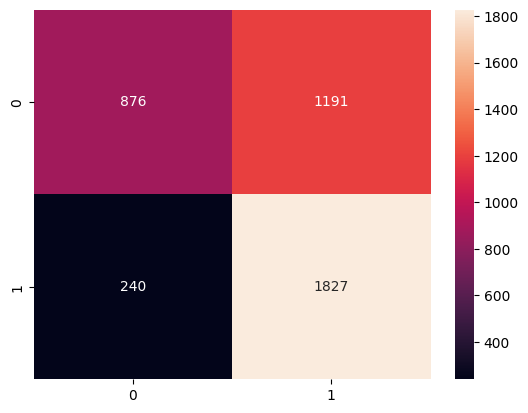

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_te, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

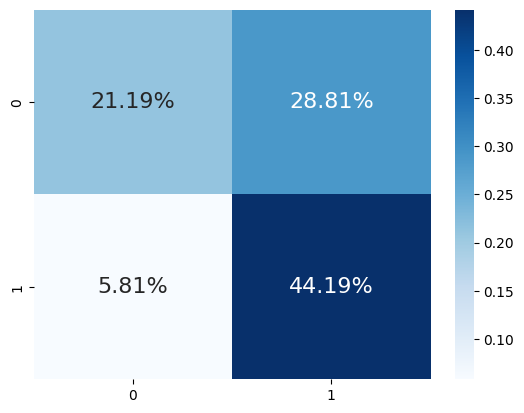

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

sns.heatmap(cm/np.sum(cm), annot=True,
            fmt='.2%', cmap='Blues', annot_kws={"fontsize":16})
sns.set(font_scale=1.4)

# Save the image to a file
plt.savefig('CNN-LSTM-LSTM.pdf')
plt.show()

# Download the image file
from google.colab import files
files.download('CNN-LSTM-LSTM.pdf')

In [24]:
#CNN-GRU-GRU model

model = keras.models.Sequential([
        keras.layers.BatchNormalization(input_shape=[64,64,3]), # Change input_shape to match the actual data shape
        keras.layers.Conv2D(filters=64, kernel_size=[7,7], strides=[1,1],
                            padding="same", activation="relu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same",
                            activation="relu"),
         keras.layers.MaxPool2D(2),
        keras.layers.Reshape((16, 16*128)), #Explicitly calculate the reshape dimensions

        keras.layers.GRU(128, return_sequences=True),
        keras.layers.GRU(64, return_sequences=True),

        keras.layers.Flatten(),

        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.15),
        keras.layers.Dense(2, activation="softmax")
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_3                │ (None, 64, 64, 3)           │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 64)          │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 16, 2048)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 16, 128)             │         836,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 16, 64)              │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,022,670 (3.90 MB)

 Trainable params: 1,022,664 (3.90 MB)

 Non-trainable params: 6 (24.00 B)

In [25]:
opt = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])
model.fit(datagen.flow(X_tr, y_tr, batch_size=32), epochs=100, validation_data=(X_va, y_va),
          callbacks=[keras.callbacks.EarlyStopping(patience=5, min_delta=0.0005, mode="min")])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


132/603 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.5812 - loss: 0.6770

KeyboardInterrupt: 

In [26]:
model.evaluate(X_te, y_te)

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6765 - loss: 0.6251


[0.6246592998504639, 0.6782776713371277]

In [ ]:
y_pred= np.argmax(model.predict(X_test), axis=1)
y_pred

In [ ]:
y_pred
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_pred)
cm

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

sns.heatmap(cm/np.sum(cm), annot=True,
            fmt='.2%', cmap='Blues', annot_kws={"fontsize":16})
sns.set(font_scale=1.4)

# Save the image to a file
plt.savefig('CNN-GRU-GRU.pdf')
plt.show()

# Download the image file
from google.colab import files
files.download('CNN-GRU-GRU.pdf')

In [ ]:
#CNN-BiLSTM-BiLSTM model

model = keras.models.Sequential([
        keras.layers.BatchNormalization(input_shape=[32,32,3]),
        keras.layers.Conv2D(filters=64, kernel_size=[7,7], strides=[1,1],
                            padding="same", activation="relu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same",
                            activation="relu"),
         keras.layers.MaxPool2D(2),

        keras.layers.Reshape((128,-1)),

        keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),

        keras.layers.Flatten(),

        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.15),
        keras.layers.Dense(2, activation="softmax")
])
model.summary()

In [ ]:
opt = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])
model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=100, validation_data=(X_val, y_val),
          callbacks=[keras.callbacks.EarlyStopping(patience=5, min_delta=0.0005, mode="min")])

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
y_pred= np.argmax(model.predict(X_test), axis=1)
y_pred

In [ ]:
y_pred
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_pred)
cm

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

sns.heatmap(cm/np.sum(cm), annot=True,
            fmt='.2%', cmap='Blues', annot_kws={"fontsize":16})
sns.set(font_scale=1.4)

# Save the image to a file
plt.savefig('CNN-BiLSTM-BiLSTM.pdf')
plt.show()

# Download the image file
from google.colab import files
files.download('CNN-BiLSTM-BiLSTM.pdf')